In [1]:
#Inizializing libraries

from __future__ import print_function
import numpy as np
import tensorflow as tf
import imageio
import time

from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import metrics, regularizers, optimizers, callbacks
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Nadam
from tensorflow.keras import backend as K

from sklearn.metrics import *

# To have the plots inside the notebook "inlin" should be True. 
# If "inlin" = False, then plots will pop out of the notebook
inlin = True # True/False
if inlin:
    %matplotlib inline
else:
    %matplotlib

import matplotlib
import matplotlib.pyplot as plt

In [2]:
#Loading images

def loadImages(folder,trgFile,n):
    def load_pics(folder,n):
        imgs = []
        for i in range(n):
            img = imageio.imread(folder+"img_{:05}.png".format(i+1))
            ch = img[:,:,0] #you only take the white pixel, to decrease the size of the image, and put it in an array
            imgs.append(ch) 
        return np.array(imgs)

    def load_labels(fn):
        return np.loadtxt(fn, usecols=0) #First column (label of the number of corners) of the file csv

    pic = load_pics(folder+"/", n)
    ndata, width, height = pic.shape

    inp = (pic/np.float32(255)).reshape(n, width, height, 1)
    trg = load_labels(trgFile) #You can get the number in the first column of the file, which is the label number
    trg = to_categorical(trg[0:n]-3) #trg[0:n] gives all the number from 0 to 10, -3 we get all the numbers from 0 to 7
#with to_categorical we transform these numbers from 0 to 7 into 8 binary class vectors (one-hot encoding)
    return inp, trg, width, height


def loadData(nTrn, nTst):
    # Load data
    (trnInp, trnTrg, imgW, imgH) = loadImages("polyAll-trn", "polyAll-trn_trg.csv", nTrn)
    (tstInp, tstTrg, imgW, imgH) = loadImages("polyAll-tst", "polyAll-tst_trg.csv", nTst)

    if tf.keras.backend.image_data_format() == 'channels_first':
        trnInp = trnInp.reshape(trnInp.shape[0], 1, imgH, imgW)
        tstInp = tstInp.reshape(tstInp.shape[0], 1, imgH, imgW)
        input_shape = (1, imgH, imgW)
    else:
        trnInp = trnInp.reshape(trnInp.shape[0], imgH, imgW, 1)
        tstInp = tstInp.reshape(tstInp.shape[0], imgH, imgW, 1)
        input_shape = (imgH, imgW, 1)

    print('trnInp shape:', trnInp.shape)
    print('tstInp shape:', tstInp.shape)
    print('trnTrg shape:', trnTrg.shape)
    print('tstTrg shape:', tstTrg.shape)


    

    
    return trnInp, trnTrg, tstInp, tstTrg, input_shape

# Get the training data
(trnInp, trnTrg, tstInp, tstTrg, input_shape) = loadData(5000,5000)



trnInp shape: (5000, 100, 100, 1)
tstInp shape: (5000, 100, 100, 1)
trnTrg shape: (5000, 8)
tstTrg shape: (5000, 8)


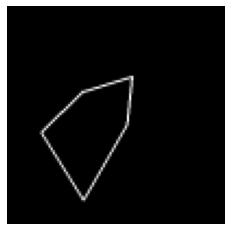

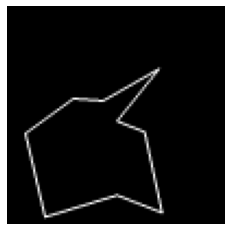

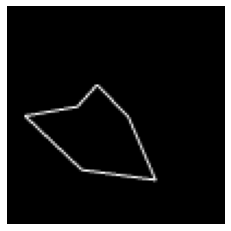

Targets:
[[0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]]


In [22]:
# Show images
width=100
height=100
plt.figure(1, figsize=(4,4))
for i in range(3):
    plt.imshow(trnInp[i].swapaxes(0,1).reshape(width,height),cmap="gray")
    plt.axis("off")
    plt.show()

print("Targets:")
print(trnTrg[:10])

(100, 100, 1)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 100, 100, 60)      2220      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 20, 20, 60)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 20, 20, 60)        90060     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 5, 5, 60)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1500)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1500)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 15) 

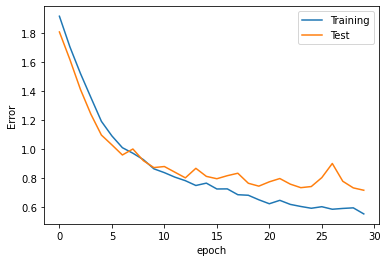

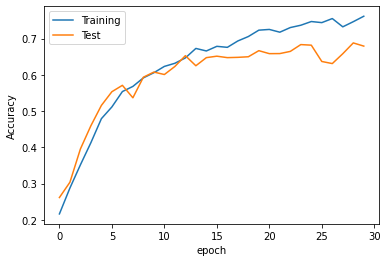

In [7]:
# Neural network model. Architecture:

# The size of the images
print(input_shape)

# Define the CNN model
model = Sequential([
    Conv2D(60, kernel_size=(6, 6), padding='same', activation='relu',
           input_shape=input_shape),
    MaxPooling2D(pool_size=(5, 5)),
    Conv2D(60, kernel_size=(5, 5), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(4, 4)),
    Flatten(),
    Dropout(0.3),
    Dense(15, activation='relu'), 
    Dense(8),
    Activation('softmax')
])

#Remark: I use the softmax output activation function since is a m-class classification problem
#Remark: I use relu in the hidden layers of the MLP because it is a non linear activation function (like relu or tanh)

#Remark: Dense(5) I used 5 hidden layers in the MLP; dropout(0.5); learning rate = 0.005
#Adam optimizer beside calculating the gradient keeps also a running average of the past gradients and a running average of the square of the past gradients.
# We use cross entropy error and the adam optimizer
class CustomCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print('Epoch')
        print(model.layers[1].get_weights())

adam = Adam(learning_rate=0.005) 
model.compile(loss='categorical_crossentropy',   
              optimizer=adam, metrics=['accuracy'])
model.summary()

# Now train the model
estimator = model.fit(trnInp, trnTrg, 
                      epochs=30, 
                      batch_size=80,
                      verbose=0,
                      validation_data=(tstInp, tstTrg), 
                      callbacks=[CustomCallback()])



#tf.keras.metrics.CategoricalAccuracy()
#Remark: I use the categorical cross-entropy error function since it is a m-class classification problem.



# Plot the training/test error
plt.plot(estimator.history['loss'], label='Training')
plt.plot(estimator.history['val_loss'], label='Test')
plt.ylabel('Error')
plt.xlabel('epoch')
plt.legend()
plt.show()

# Plot the training/test accuracy
plt.plot(estimator.history['accuracy'], label='Training')
plt.plot(estimator.history['val_accuracy'], label='Test')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()







In [11]:
ypred = model.predict(tstInp)
input_size = np.shape(tstTrg)[0]
max_index=tf.math.top_k(ypred)
print('The max index is', max_index)
print('The max index is', tf.math.top_k(tstTrg))

for i in range(20):
    if tf.math.top_k(tstTrg)[i][1] != tf.math.top_k(ypred)[i][1]:
        print("True value", tf.math.top_k(tstTrg)[i][1], "Predicted value", tf.math.top_k(ypred)[i][1], i)


The max index is TopKV2(values=<tf.Tensor: id=31684, shape=(5000, 1), dtype=float32, numpy=
array([[0.61315864],
       [0.64325434],
       [0.5988936 ],
       ...,
       [0.643364  ],
       [0.644512  ],
       [0.99994576]], dtype=float32)>, indices=<tf.Tensor: id=31685, shape=(5000, 1), dtype=int32, numpy=
array([[6],
       [6],
       [1],
       ...,
       [2],
       [6],
       [0]], dtype=int32)>)
The max index is TopKV2(values=<tf.Tensor: id=31688, shape=(5000, 1), dtype=float32, numpy=
array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)>, indices=<tf.Tensor: id=31689, shape=(5000, 1), dtype=int32, numpy=
array([[5],
       [6],
       [1],
       ...,
       [1],
       [6],
       [0]], dtype=int32)>)
True value tf.Tensor([1.], shape=(1,), dtype=float32) Predicted value tf.Tensor([0.64325434], shape=(1,), dtype=float32) 0


IndexError: tuple index out of range

In [5]:

ypred = model.predict(tstInp)
print(ypred.size)

input_size = np.shape(trnTrg)[0]

idx   = [np.where(ypred[i], np.max(ypred[i])) for i in range(input_size)]
idx_t = [np.where(trnTrg[i], 1) for i in range(input_size)]
for i in range(300):
    if ypred[idx[i][0]][idx[i][1]] != trnTrg[idx_t[i][0]][idx_t[i][1]]:
        
        print("True value", ytrue[idx_t[i][0]][idx_t[i][1]] ,"Predicted value", ypred[idx[i][0]][idx[i][1]])
        plt.figure(1, figsize=(15,10))
        plt.imshow(trnInp[i,:,:,:].swapaxes(0,1).reshape(width,10*height),cmap="gray")
        plt.axis("off")
        plt.show()    
    


#binary case
    #one_correct = np.sum((ytrue==1)*(ypred > threshold))
    #zero_correct = np.sum((ytrue==0)*(ypred <= threshold))
    #sensitivity = one_correct / np.sum(ytrue==1)
    #specificity = zero_correct / np.sum(ytrue==0)
    #accuracy = (one_correct + zero_correct) / len(ytrue)


40000


ValueError: either both or neither of x and y should be given

[0. 0. 0. 1. 0. 0. 0. 0.]


<Figure size 1296x864 with 0 Axes>

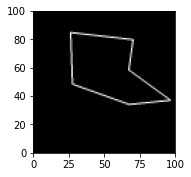

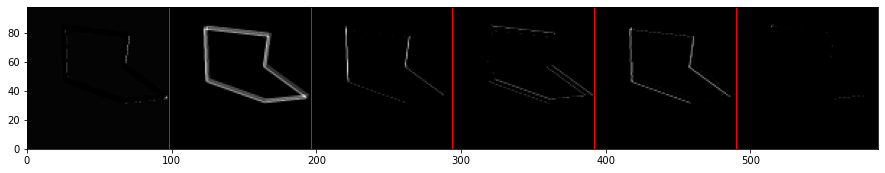

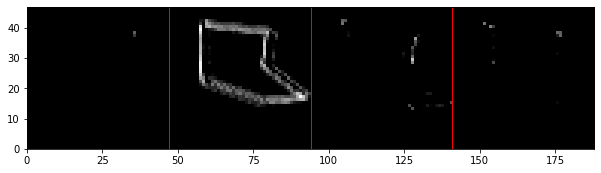

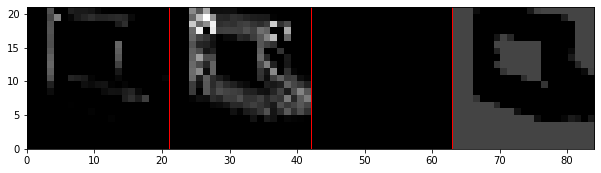

In [4]:
# Show how the image is filtered. Show the output result after applying each filter.

# if True then Maxpooling will be applied before showing the filter
post_pool = False

# The image index to show
idx = 10

kind = MaxPooling2D if post_pool else Conv2D
outs = [l.output for l in model.layers if isinstance(l, kind)]
intermediate = K.function([model.layers[0].input], outs)
print(tstTrg[idx])
states = [tstInp[idx:idx+1]] + intermediate([tstInp[idx:idx+1]])
plt.figure(figsize=(18,12))                    
for k,s in enumerate(states):
    plt.figure(figsize=(18,12))
    plt.subplot(len(outs)+1,1,k+1)
    pics = s[0]
    pics = np.rollaxis(pics,2,0)
    rows = 2 if pics.shape[0] > 8 else 1
    cols = pics.shape[0]//rows
    imgshape = pics.shape[1:]
    pics = pics.reshape((rows,cols)+imgshape)
    pics = pics.swapaxes(1,2)
    pics = pics.reshape((pics.shape[0]*pics.shape[1], pics.shape[2]*pics.shape[3]))
    extent = (0,cols*imgshape[0], 0,rows*imgshape[1])
    plt.imshow(pics,cmap='gray',extent=extent)
    for r in range(1,rows):
        plt.plot([0,cols*imgshape[0]], [r*imgshape[1], r*imgshape[1]], color='r', linestyle='-', linewidth=1)
    for c in range(1,cols):
        plt.plot([c*imgshape[0], c*imgshape[0]], [0,rows*imgshape[1]], color='r', linestyle='-', linewidth=1)


